(sec:sgd)=
# Optimization

In this chapter, we will present variants of the **Gradient Descent** optimization strategy and show how they can be used to optimize neural network parameters.

Let us start with the basic Gradient Descent algorithm and its limitations.

```{prf:algorithm} Gradient Descent
:label: algo:gd

**Input:** A dataset $\mathcal{D} = (X, y)$

1. Initialize model parameters $\theta$
2. for $e = 1 .. E$

    1. for $(x_i, y_i) \in \mathcal{D}$

        1. Compute prediction $\hat{y}_i = m_\theta(x_i)$
        2. Compute gradient $\nabla_\theta \mathcal{L}_i$

    2. Compute overall gradient $\nabla_\theta \mathcal{L} = \frac{1}{n} \sum_i \nabla_\theta \mathcal{L}_i$
    3. Update parameters $\theta$ based on $\nabla_\theta \mathcal{L}$
```

The typical update rule for the parameters $\theta$ at iteration $t$ is

$$
    \theta^{(t+1)} \leftarrow \theta^{(t)} - \rho \nabla_\theta \mathcal{L}
$$

where $\rho$ is an important hyper-parameter of the method, called the learning rate.
Basically, gradient descent updates $\theta$ in the direction of steepest decrease of the loss $\mathcal{L}$.

As one can see in the previous algorithm, when performing gradient descent, model parameters are updated once per epoch, which means a full pass over the whole dataset is required before the update can occur.
When dealing with large datasets, this is a strong limitation, which motivates the use of stochastic variants.

## Stochastic Gradient Descent (SGD)

The idea behind the Stochastic Gradient Descent algorithm is to get cheap estimates for the quantity 

$$
    \nabla_\theta \mathcal{L}(\mathcal{D} ; m_\theta) = \frac{1}{n} \sum_{(x_i, y_i) \in \mathcal{D}} \nabla_\theta \mathcal{L}(x_i, y_i ; m_\theta)
$$

where $\mathcal{D}$ is the whole training set.
To do so, one draws subsets of data, called _minibatches_, and 

$$
    \nabla_\theta \mathcal{L}(\mathcal{B} ; m_\theta) = \frac{1}{b} \sum_{(x_i, y_i) \in \mathcal{B}} \nabla_\theta \mathcal{L}(x_i, y_i ; m_\theta)
$$
is used as an estimator for $\nabla_\theta \mathcal{L}(\mathcal{D} ; m_\theta)$.
This results in the following algorithm in which, interestingly, parameter updates occur after each minibatch, which is multiple times per epoch.

```{prf:algorithm} Stochastic Gradient Descent
:label: algo:sgd

**Input:** A dataset $\mathcal{D} = (X, y)$

1. Initialize model parameters $\theta$
2. for $e = 1 .. E$

    1. for $t = 1 .. n_\text{minibatches}$

        1. Draw minibatch $\mathcal{B}$ as a random sample of size $b$ from $\mathcal{D}$
        1. for $(x_i, y_i) \in \mathcal{B}$

            1. Compute prediction $\hat{y}_i = m_\theta(x_i)$
            2. Compute gradient $\nabla_\theta \mathcal{L}_i$

        2. Compute minibatch-level gradient $\nabla_\theta \mathcal{L}_{\mathcal{B}} = \frac{1}{b} \sum_i \nabla_\theta \mathcal{L}_i$
        3. Update parameters $\theta$ based on $\nabla_\theta \mathcal{L}_{\mathcal{B}}$
```

As a consequence, when using SGD, parameter updates are more frequent, but they are "noisy" since they are based on an minibatch estimation of the gradient instead of relying on the true gradient, as illustrated below:

In [1]:
import numpy as np

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML

plt.ion();

import matplotlib.animation as animation
from matplotlib import rc
import scipy.optimize as optim


def grad(X, y, alpha, lambd):
    p = np.exp(-y * X.dot(alpha))
    d = - X.T.dot(p * y / (1 + p)) + lambd * alpha
    return d

def norm(x):
    return np.sqrt(np.sum(x ** 2))

def cost(X, y, alpha, lambd):
    p = np.exp(-y * X.dot(alpha))
    return np.sum(np.log(1 + p)) + .5 * lambd * norm(alpha) ** 2
    # TODO: 1/n pour pas que le SGD fasse nimp


def optim_gd(X, y, alpha_init, n_epochs, lambd, rho):
    alphas = [alpha_init]
    for _ in range(n_epochs):
        d = - grad(X, y, alphas[-1], lambd)        
        alphas.append(alphas[-1] + rho * d)

    return np.concatenate(alphas, axis=0).reshape((-1, alpha_init.shape[0]))


def optim_sgd(X, y, alpha_init, n_epochs, lambd, rho, minibatch_size):
    alphas = [alpha_init]
    for i in range(n_epochs):
        for j in range(X.shape[0] // minibatch_size):
            scaled_lambda = lambd / (X.shape[0] // minibatch_size)
            indices_minibatch = np.random.randint(X.shape[0], size=minibatch_size)
            X_minibatch = X[indices_minibatch]
            y_minibatch = y[indices_minibatch]
            d = - grad(X_minibatch, y_minibatch, alphas[-1], scaled_lambda)
              
            alphas.append(alphas[-1] + rho * d)

    return np.concatenate(alphas, axis=0).reshape((-1, alpha_init.shape[0]))


def stretch_to_range(lim, sz_range):
    middle = (lim[0] + lim[1]) / 2
    return [middle - sz_range / 2, middle + sz_range / 2]


def get_lims(*alphas_list):
    xlims = [
        min([alphas[:, 0].min() for alphas in alphas_list]) - 1,
        max([alphas[:, 0].max() for alphas in alphas_list]) + 1
    ]
    ylims = [
        min([alphas[:, 1].min() for alphas in alphas_list]) - 1,
        max([alphas[:, 1].max() for alphas in alphas_list]) + 1
    ]
    if xlims[1] - xlims[0] > ylims[1] - ylims[0]:
        ylims = stretch_to_range(ylims, xlims[1] - xlims[0])
    else:
        xlims = stretch_to_range(xlims, ylims[1] - ylims[0])
    return xlims, ylims


def gen_anim(X, y, alphas_gd, alphas_sgd, alpha_star, lambd, xlims, ylims, n_steps_per_epoch):
    global lines_alphas
    font = {'size'   : 18}
    # rc('font', **font)

    n = 40
    nn = n * n
    xv, yv = np.meshgrid(np.linspace(xlims[0], xlims[1], n),
                         np.linspace(ylims[0], ylims[1], n))
    xvisu = np.concatenate((xv.ravel()[:, None], yv.ravel()[:, None]), axis=1)

    pv = np.zeros(nn)
    for i in range(nn):
        pv[i] = cost(X, y, xvisu[i], lambd)

    P = pv.reshape((n,n))
    
    fig = plt.figure(figsize=(13, 6))
    axes = [plt.subplot(1, 2, i + 1) for i in range(2)]

    lines_alphas = []
    texts = []  
    for ax, alphas, title in zip(axes, 
                                 [alphas_gd, alphas_sgd],
                                 ["Gradient Descent", "Stochastic Gradient Descent"]):
        ax.contour(xv, yv, P, alpha=0.5)
        ax.plot(alphas[0, 0], alphas[0, 1], 'ko', fillstyle='none')
        line_alphas,  = ax.plot(alphas[:1, 0], alphas[:1, 1], marker="x")
        lines_alphas.append(line_alphas)
        
        ax.plot(alpha_star[0:1], alpha_star[1:2], '+r')

        ax.set_xlabel("$w_0$")
        ax.set_ylabel("$w_1$")
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(title)
        text_epoch = ax.text(0.7 * xlims[1], 0.8 * ylims[1], s="Epoch 0")
        texts.append(text_epoch)

    def animate(i):
        global lines_alphas
        
        for line_alphas, text_epoch, alphas in zip(lines_alphas, texts, [alphas_gd, alphas_sgd]):
            line_alphas.set_xdata(alphas[:i, 0])
            line_alphas.set_ydata(alphas[:i, 1])
            
            text_epoch.set_text(f"Epoch {i // n_steps_per_epoch}")
        return lines_alphas + texts

    return animation.FuncAnimation(fig, animate, interval=500, blit=False, save_count=len(alphas_gd))


# Data

np.random.seed(0)
X = np.random.rand(20, 2) * 3 - 1.5
y = (X[:, 0] > 0.).astype(int)
y[y == 0] = -1

# Optim

lambd = .1
rho = 2e-1
alpha_init = np.array([1., -3.])
n_epochs = 10
minibatch_size = 4

res_optim = optim.minimize(fun=lambda alpha: cost(X, y, alpha, lambd),
                           x0=alpha_init, 
                           jac=lambda alpha: grad(X, y, alpha, lambd))
alpha_star = res_optim["x"]

alphas_gd = optim_gd(X, y, alpha_init, n_epochs, lambd, rho)
alphas_sgd = optim_sgd(X, y, alpha_init, n_epochs, lambd, rho, minibatch_size)

# Visualization
xlims, ylims = get_lims(alphas_gd, alphas_sgd, np.array([alpha_star]))

ani = gen_anim(X, y, 
               np.repeat(alphas_gd, 20 // minibatch_size, axis=0), alphas_sgd,
               alpha_star, lambd, xlims, ylims, 
               n_steps_per_epoch=20 // minibatch_size)
plt.close()
HTML(ani.to_jshtml())

Apart from implying from more frequent parameter updates, SGD has an extra benefit in terms of optimization, which is key for neural networks.
Indeed, as one can see below, contrary to what we had in the Perceptron case, the MSE loss (and the same applies for the logistic loss) is no longer convex in the model parameters as soon as the model has at least one hidden layer:

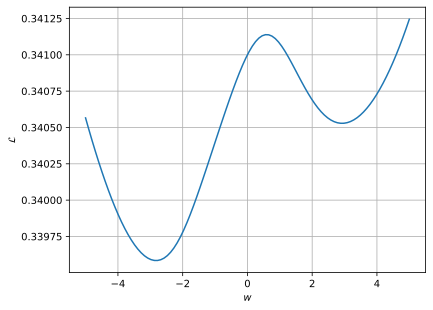

In [2]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def model_forward_loss(weights, biases, X, y):
    outputs = X
    for w, b in zip(weights, biases):
        outputs = sigmoid(outputs @ w + b)
    loss = np.mean((outputs - y) ** 2)
    loss += .0001 * np.sum([(w ** 2).sum() for w in weights])
    return loss


np.random.seed(0)
w0 = np.linspace(-5, 5, 100)
X = np.random.randn(150, 6)
y = np.array([0] * 75 + [1] * 75)
weights = [
    np.random.randn(6, 20),
    np.random.randn(20, 1)
]
biases = [
    np.random.randn(1, 20),
    np.random.randn(1, 1)
]

losses = []
for wi in w0:
    weights[0][3, 9] = wi
    losses.append(model_forward_loss(weights, biases, X, y))


plt.plot(w0, losses)
plt.grid('on')
plt.xlabel('$w$')
plt.ylabel('$\mathcal{L}$');

Gradient Descent is known to suffer from local optima, and such loss landscapes are a serious problem for GD.
On the other hand, Stochastic Gradient Descent is likely to benefit from noisy gradient estimations to escape local minima.

## A note on Adam

Adam {cite}`2015-kingma` is a variant of the Stochastic Gradient Descent method.
It differs in the definition of the steps to be performed at each parameter update.

First, it uses what is called momentum, which basically consists in relying on past gradient updates to smooth out the trajectory in parameter space during optimization.
An interactive illustration of momentum can be found in {cite}`goh2017why`.

The resulting plugin replacement for the gradient is:

$$
  \mathbf{m}^{(t+1)} \leftarrow \frac{1}{1 - \beta_1^t} \left[\beta_1 \mathbf{m}^{(t)} + (1 - \beta_1) \nabla_\theta \mathcal{L} \right]
$$

When $\beta_1$ is zero, we have $\mathbf{m}^{(t+1)} = \nabla_\theta \mathcal{L}$ and for $\beta_1 \in ]0, 1[$, $\mathbf{m}^{(t+1)}$ balances the current gradient estimate with information about past estimates, stored in $\mathbf{m}^{(t)}$.

Another important difference between SGD and the Adam variant consists in using an adaptive learning rate.
In other words, instead of using the same learning rate $\rho$ for all model parameters, the learning rate for a given parameter $\theta_i$ is defined as:

$$
  \hat{\rho}^{(t+1)}(\theta_i) = \frac{\rho}{\sqrt{s^{(t+1)}(\theta_i)+\epsilon}}
$$

where $\epsilon$ is a small constant and

$$
  s^{(t+1)}(\theta_i) = \frac{1}{1 - \beta_2^t} \left[ \beta_{2} s^{(t)}(\theta_i) + (1-\beta_{2}) \left(\nabla_{\theta_i} \mathcal{L}\right)^2\right]
$$

Here also, the $s$ term uses momentum. As a result, the learning rate will be lowered for parameters which have suffered large updates in the past iterations.

Overall, the Adam update rule is:

$$
  \theta^{(t+1)} \leftarrow \theta^{(t)} - \hat{\rho}^{(t+1)}(\theta) \mathbf{m}^{(t+1)}
$$

## The curse of depth

Let us consider the following neural network:

```{tikz}
    \tikzset{every path/.style={line width=1pt}}

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in0) at  (0, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in1) at  (0, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in2) at  (0, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in3) at  (0, 1) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in4) at  (0, 0) {};

    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_0) at  (3, 5) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_1) at  (3, 4) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_2) at  (3, 3) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_3) at  (3, 2) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_4) at  (3, 1) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_5) at  (3, 0) {};
    \node[draw=red, circle, minimum size=17pt,inner sep=0pt] (h1_6) at  (3, -1) {};

    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_0) at  (6, 5) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_1) at  (6, 4) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_2) at  (6, 3) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_3) at  (6, 2) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_4) at  (6, 1) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_5) at  (6, 0) {};
    \node[draw=purple, circle, minimum size=17pt,inner sep=0pt] (h2_6) at  (6, -1) {};
    
    \node[draw=blue, circle, minimum size=17pt,inner sep=0pt] (out_0) at  (9, 1) {};
    \node[draw=blue, circle, minimum size=17pt,inner sep=0pt] (out_1) at  (9, 2) {};
    \node[draw=blue, circle, minimum size=17pt,inner sep=0pt] (out_2) at  (9, 3) {};

    \draw[->, color=red] (in0) -- (h1_0);
    \draw[->, color=red] (in0) -- (h1_1);
    \draw[->, color=red] (in0) -- (h1_2);
    \draw[->, color=red] (in0) -- (h1_3);
    \draw[->, color=red] (in0) -- (h1_4);
    \draw[->, color=red] (in0) -- (h1_5);
    \draw[->, color=red] (in0) -- (h1_6);
    \draw[->, color=red] (in1) -- (h1_0);
    \draw[->, color=red] (in1) -- (h1_1);
    \draw[->, color=red] (in1) -- (h1_2);
    \draw[->, color=red] (in1) -- (h1_3);
    \draw[->, color=red] (in1) -- (h1_4);
    \draw[->, color=red] (in1) -- (h1_5);
    \draw[->, color=red] (in1) -- (h1_6);
    \draw[->, color=red] (in2) -- (h1_0);
    \draw[->, color=red] (in2) -- (h1_1);
    \draw[->, color=red] (in2) -- (h1_2);
    \draw[->, color=red] (in2) -- (h1_3);
    \draw[->, color=red] (in2) -- (h1_4);
    \draw[->, color=red] (in2) -- (h1_5);
    \draw[->, color=red] (in2) -- (h1_6);
    \draw[->, color=red] (in3) -- (h1_0);
    \draw[->, color=red] (in3) -- (h1_1);
    \draw[->, color=red] (in3) -- (h1_2);
    \draw[->, color=red] (in3) -- (h1_3);
    \draw[->, color=red] (in3) -- (h1_4);
    \draw[->, color=red] (in3) -- (h1_5);
    \draw[->, color=red] (in3) -- (h1_6);
    \draw[->, color=red] (in4) -- (h1_0);
    \draw[->, color=red] (in4) -- (h1_1);
    \draw[->, color=red] (in4) -- (h1_2);
    \draw[->, color=red] (in4) -- (h1_3);
    \draw[->, color=red] (in4) -- (h1_4);
    \draw[->, color=red] (in4) -- (h1_5);
    \draw[->, color=red] (in4) -- (h1_6);

    \draw[->, color=purple] (h1_0) -- (h2_0);
    \draw[->, color=purple] (h1_1) -- (h2_0);
    \draw[->, color=purple] (h1_2) -- (h2_0);
    \draw[->, color=purple] (h1_3) -- (h2_0);
    \draw[->, color=purple] (h1_4) -- (h2_0);
    \draw[->, color=purple] (h1_5) -- (h2_0);
    \draw[->, color=purple] (h1_6) -- (h2_0);
    \draw[->, color=purple] (h1_0) -- (h2_1);
    \draw[->, color=purple] (h1_1) -- (h2_1);
    \draw[->, color=purple] (h1_2) -- (h2_1);
    \draw[->, color=purple] (h1_3) -- (h2_1);
    \draw[->, color=purple] (h1_4) -- (h2_1);
    \draw[->, color=purple] (h1_5) -- (h2_1);
    \draw[->, color=purple] (h1_6) -- (h2_1);
    \draw[->, color=purple] (h1_0) -- (h2_2);
    \draw[->, color=purple] (h1_1) -- (h2_2);
    \draw[->, color=purple] (h1_2) -- (h2_2);
    \draw[->, color=purple] (h1_3) -- (h2_2);
    \draw[->, color=purple] (h1_4) -- (h2_2);
    \draw[->, color=purple] (h1_5) -- (h2_2);
    \draw[->, color=purple] (h1_6) -- (h2_2);
    \draw[->, color=purple] (h1_0) -- (h2_3);
    \draw[->, color=purple] (h1_1) -- (h2_3);
    \draw[->, color=purple] (h1_2) -- (h2_3);
    \draw[->, color=purple] (h1_3) -- (h2_3);
    \draw[->, color=purple] (h1_4) -- (h2_3);
    \draw[->, color=purple] (h1_5) -- (h2_3);
    \draw[->, color=purple] (h1_6) -- (h2_3);
    \draw[->, color=purple] (h1_0) -- (h2_4);
    \draw[->, color=purple] (h1_1) -- (h2_4);
    \draw[->, color=purple] (h1_2) -- (h2_4);
    \draw[->, color=purple] (h1_3) -- (h2_4);
    \draw[->, color=purple] (h1_4) -- (h2_4);
    \draw[->, color=purple] (h1_5) -- (h2_4);
    \draw[->, color=purple] (h1_6) -- (h2_4);
    \draw[->, color=purple] (h1_0) -- (h2_5);
    \draw[->, color=purple] (h1_1) -- (h2_5);
    \draw[->, color=purple] (h1_2) -- (h2_5);
    \draw[->, color=purple] (h1_3) -- (h2_5);
    \draw[->, color=purple] (h1_4) -- (h2_5);
    \draw[->, color=purple] (h1_5) -- (h2_5);
    \draw[->, color=purple] (h1_6) -- (h2_5);
    \draw[->, color=purple] (h1_0) -- (h2_6);
    \draw[->, color=purple] (h1_1) -- (h2_6);
    \draw[->, color=purple] (h1_2) -- (h2_6);
    \draw[->, color=purple] (h1_3) -- (h2_6);
    \draw[->, color=purple] (h1_4) -- (h2_6);
    \draw[->, color=purple] (h1_5) -- (h2_6);
    \draw[->, color=purple] (h1_6) -- (h2_6);

    \draw[->, color=blue] (h2_0) -- (out_0);
    \draw[->, color=blue] (h2_1) -- (out_0);
    \draw[->, color=blue] (h2_2) -- (out_0);
    \draw[->, color=blue] (h2_3) -- (out_0);
    \draw[->, color=blue] (h2_4) -- (out_0);
    \draw[->, color=blue] (h2_5) -- (out_0);
    \draw[->, color=blue] (h2_6) -- (out_0);
    \draw[->, color=blue] (h2_0) -- (out_1);
    \draw[->, color=blue] (h2_1) -- (out_1);
    \draw[->, color=blue] (h2_2) -- (out_1);
    \draw[->, color=blue] (h2_3) -- (out_1);
    \draw[->, color=blue] (h2_4) -- (out_1);
    \draw[->, color=blue] (h2_5) -- (out_1);
    \draw[->, color=blue] (h2_6) -- (out_1);
    \draw[->, color=blue] (h2_0) -- (out_2);
    \draw[->, color=blue] (h2_1) -- (out_2);
    \draw[->, color=blue] (h2_2) -- (out_2);
    \draw[->, color=blue] (h2_3) -- (out_2);
    \draw[->, color=blue] (h2_4) -- (out_2);
    \draw[->, color=blue] (h2_5) -- (out_2);
    \draw[->, color=blue] (h2_6) -- (out_2);


    \node[fill=white, text=red] (beta0) at  (1.5, 2) {$\mathbf{w^{(0)}}$};
    \node[fill=white, text=purple] (beta1) at  (4.5, 2) {$\mathbf{w^{(1)}}$};
    \node[fill=white, text=blue] (beta2) at  (7.5, 2) {$\mathbf{w^{(2)}}$};
```

and let us recall that, at a given layer $(\ell)$, the layer output is computed as

$$
  a^{(\ell)} = \varphi(o^{(\ell)}) = \varphi(w^{(\ell - 1)} a^{(\ell - 1)})
$$

where $\varphi$ is the activation function for the given layer (we ignore the bias terms in this simplified example).

In order to perform (stochastic) gradient descent, gradients of the loss with respect to model parameters need to be computed.

By using the chain rule, these gradients can be expressed as:

\begin{align*}
  \frac{\partial \mathcal{L}}{\partial w^{(2)}} &= \frac{\partial \mathcal{L}}{\partial a^{(3)}}
{\color{blue}\frac{\partial a^{(3)}}{\partial o^{(3)}} \frac{\partial o^{(3)}}{\partial w^{(2)}}} \\
  \frac{\partial \mathcal{L}}{\partial w^{(1)}} &= \frac{\partial \mathcal{L}}{\partial a^{(3)}}
{\color{blue}\frac{\partial a^{(3)}}{\partial o^{(3)}} \frac{\partial o^{(3)}}{\partial a^{(2)}}}
{\color{purple}\frac{\partial a^{(2)}}{\partial o^{(2)}} \frac{\partial o^{(2)}}{\partial w^{(1)}}} \\
  \frac{\partial \mathcal{L}}{\partial w^{(0)}} &= \frac{\partial \mathcal{L}}{\partial a^{(3)}}
{\color{blue}\frac{\partial a^{(3)}}{\partial o^{(3)}} \frac{\partial o^{(3)}}{\partial a^{(2)}}}
{\color{purple}\frac{\partial a^{(2)}}{\partial o^{(2)}} \frac{\partial o^{(2)}}{\partial a^{(1)}}}
{\color{red}\frac{\partial a^{(1)}}{\partial o^{(1)}} \frac{\partial o^{(1)}}{\partial w^{(0)}}}
\end{align*}

There are important insights to grasp here.

First, one should notice that weights that are further from the output of the model inherit gradient rules made of more terms.
As a consequence, when some of these terms get smaller and smaller, there is a higher risk for those weights that their gradients collapse to 0, this is called the **vanishing gradient** effect, which is a very common phenomenon in deep neural networks (_i.e._ those networks made of many layers).

Second, some terms are repeated in these formulas, and in general, terms of the form $\frac{\partial a^{(\ell)}}{\partial o^{(\ell)}}$ and $\frac{\partial o^{(\ell)}}{\partial a^{(\ell-1)}}$ are present in several places.
These terms can be further developed as:

\begin{align*}
  \frac{\partial a^{(\ell)}}{\partial o^{(\ell)}} &= \varphi^\prime (o^{(\ell)}) \\
  \frac{\partial o^{(\ell)}}{\partial a^{(\ell - 1)}} &= w^{(\ell - 1)}
\end{align*}

Let us inspect what the derivatives of standard activation functions look like:

2022-10-05 21:15:21.743525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 21:15:21.885829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-05 21:15:21.885865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-05 21:15:21.912279: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-10-05 21:15:22.615008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-05 21:15:22.615095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-05 21:15:22.615103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-10-05 21:15:23.427302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-05 21:15:23.427338: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-05 21:15:23.427357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az183-267): /proc/driver/nvidia/version does not exist
2022-10-05 21:15:23.427648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


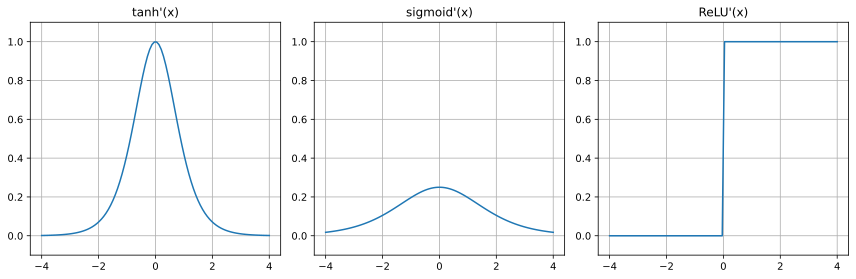

In [3]:
import tensorflow as tf

def tanh(x):
    return 2. / (1. + tf.exp(-2 * x)) - 1.

def sigmoid(x):
    return 1. / (1. + tf.exp(-x))


x = tf.Variable(tf.linspace(-4, 4, 100))
with tf.GradientTape() as tape_grad:
    tan_x = tanh(x)
with tf.GradientTape() as tape_sig:
    sig_x = sigmoid(x)
with tf.GradientTape() as tape_relu:
    relu_x = tf.nn.relu(x)

grad_tanh_x = tape_grad.gradient(tan_x, x)
grad_sig_x = tape_sig.gradient(sig_x, x)
grad_relu_x = tape_relu.gradient(relu_x, x)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(x.numpy(), grad_tanh_x)
plt.grid('on')
plt.ylim([-.1, 1.1])
plt.title("tanh'(x)")

plt.subplot(1, 3, 2)
plt.plot(x.numpy(), grad_sig_x)
plt.grid('on')
plt.ylim([-.1, 1.1])
plt.title("sigmoid'(x)")

plt.subplot(1, 3, 3)
plt.plot(x.numpy(), grad_relu_x)
plt.grid('on')
plt.ylim([-.1, 1.1])
plt.title("ReLU'(x)")

plt.tight_layout();

One can see that the derivative of ReLU has a wider range of input values for which it is non-zero (typically the whole range of positive input values) than its competitors, which makes it a very attractive candidate activation function for deep neural networks, as we have seen that the $\frac{\partial a^{(\ell)}}{\partial o^{(\ell)}}$ term appears repeatedly in chain rule derivations.

## Wrapping things up in `keras`

In `keras`, loss and optimizer information are passed at compile time:

In [4]:
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.models import Sequential

model = Sequential([
    InputLayer(input_shape=(10, )),
    Dense(units=20, activation="relu"),
    Dense(units=3, activation="softmax")
])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 20)                220       


 dense_1 (Dense)             (None, 3)                 63        


Total params: 283


Trainable params: 283


Non-trainable params: 0


_________________________________________________________________


In [5]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In terms of losses:

* `"mse"` is the mean squared error loss,
* `"binary_crossentropy"` is the logistic loss for binary classification,
* `"categorical_crossentropy"` is the logistic loss for multi-class classification.

The optimizers defined in this section are available as `"sgd"` and `"adam"`.
In order to get control over optimizer hyper-parameters, one can alternatively use the following syntax:

In [6]:
from tensorflow.keras.optimizers import Adam, SGD

# Not a very good idea to tune beta_1 
# and beta_2 parameters in Adam
adam_opt = Adam(learning_rate=0.001, 
                beta_1=0.9, beta_2=0.9)

# In order to use SGD with a custom learning rate:
# sgd_opt = SGD(learning_rate=0.001)

model.compile(loss="categorical_crossentropy", optimizer=adam_opt)

## Parameter initialization and data standardization

**TODO**



## References

```{bibliography}
:filter: docname in docnames
```